# **CNN Contest**

Previous networks do not perform well on CIFAR-10 dataset. Design your own architecture (based on MLPs) and set the corresponding hyper-parameters in order to achieve better performance on the test set. Some parameters to focus on are listed below:

#### *Network's parameters*:

- Number of layers;
- Number of neurons per layer;
- Activation functions;
- Weights initialization;
- Dropout Rate.

#### *Training parameters*:
- Learning rate;
- Number of epochs;
- Optimizer;
- Batch size.

#### *Data*:
- Data augmentation.

You can also use different training techniques (e.g., early stopping, LR schedule) or consider ensemble methods.

#### *Pre-trained networks*:
- Use different pre-trained networks.

In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = False

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

In [4]:
def create_validation_set(train_data, train_percentage, test_transforms):

  # Split train data into train and validation sets
  # (10% of training set will be used as validation set)
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transforms

  return valid_data

In [5]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [6]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [7]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.

  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [8]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()

    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [9]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [10]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [11]:
def predict(model, iterator, device):

  # Evaluation mode
  model.eval()

  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)

  return labels, pred


In [12]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [13]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

100%|██████████| 170M/170M [00:05<00:00, 30.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [14]:
# Normalize CIFAR10 (using values found on the internet to be better)
mean_imagenet = [0.4914, 0.4822, 0.4465] #[0.485, 0.456, 0.406]
std_imagenet = [0.2470, 0.2435, 0.2616] #[0.229, 0.224, 0.225]

In [15]:
# Compositions of transformations
# WE USE DATA AUGMENTATION !
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.RandomCrop(size = 32, padding=4), # random cropping of 32x32 after zero padding by 4 (i.e then on 40x40 image)
                                                   torchvision.transforms.RandomHorizontalFlip(p=0.5), # 50% of horizontal flip
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])




test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean_imagenet, std_imagenet)
])

In [16]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )


In [17]:
valid_data = create_validation_set(train_data, 0.8, test_transforms) # SMALLER VALIDATION SET

Number training examples: 40000
Number validation examples: 10000


In [18]:
# Create iterators
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size=BATCH_SIZE)

**RESNET18**

Just optimizing final layer


In [19]:
%%capture
resnet18_feat_extract = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

One issue we noticed is that ResNet18 is trained on 224x224 inputs, while CIFAR10 gives 32x32 inputs. 

This could lead to weaker performance. 

If we resize to 224x224, we don't gain any new picture information and just stretch the image in ways that don't resemble the number nicely. Therefore, we will rather update the ResNet18 structure such that it can deal with the smaller 32x32 input.

In [20]:
print(resnet18_feat_extract)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# We change the STEM block of ResNet : As we already have 32x32 images, we don't want to heavily downsample the spatial dimension (ResNet trained on 224x224)
# ResNet18 STEM convolution :  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# ResNet18 STEM Pooling : (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
# On a 224x224 input :
# After STEM convolution, we get ((224-7+2*3)/2) + 1 = 112.5 (rounded 112)
# After the pooling we then have ((112-3+2*1)/2) + 1 = 56.5 (rounded 56)
# So we have 56x56x64 input
# Our original input is 32x32x3 ; as this is already smaller than the hard downsampled variant trained for in ImageNet, we don't want any downsampling in the STEM block
# We just need to adjust such that we have the correct depth (64) ; for that, we will use a 3x3 conv layer with stride of 1 and padding of (3-1)/2 = 1 such that we keep the spatial dimension the same
# We don't use any pooling!
# Furthermore, the ResNet works in stages (blocks) of Conv blocks (with residual connections), that are built such that they keep the spatial dimension the same ; then they double the depth and half the spatial dimension in every new stage
# Our ResNet18 has 4 of these stages, i.e. we would go from 32->16->8->4 ; that we can live with (as normally it goes from 56->32->16->8, which is similar enough (just factor 2))
# We keep the last pooling layer

resnet18_feat_extract.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
resnet18_feat_extract.maxpool = nn.Identity()

OUTPUT_DIM = 10
num_features = resnet18_feat_extract.fc.in_features # will be the same due to the pooling (i.e. creates 1x1xdepth output and depth is in_features in this case)

resnet18_feat_extract.fc = nn.Linear(num_features, 10)

In [24]:
print(resnet18_feat_extract)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [25]:
#https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
#optimizer = optim.SGD(resnet18_feat_extract.parameters(), lr=0.1,
#                      momentum=0.9, weight_decay=5e-4)
# LR scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # 200 due to 200 EPOCHS IN PAPER


N_EPOCHS = 50


# Optimizer
optimizer = torch.optim.SGD(resnet18_feat_extract.parameters(),
                          lr=0.001,
                          momentum=0.9,
                          weight_decay=1e-4,
                          nesterov=True)


# Loss
#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy


# Put on GPU
criterion = criterion.to(device)
resnet18_feat_extract = resnet18_feat_extract.to(device)


In [26]:

train_losses_resnet18_feat_extract, train_accs_resnet18_feat_extract, valid_losses_resnet18_feat_extract, valid_accs_resnet18_feat_extract = model_training(N_EPOCHS,
                                                                                                                            resnet18_feat_extract,
                                                                                                                            train_iterator,
                                                                                                                            valid_iterator,
                                                                                                                            optimizer,
                                                                                                                            criterion,
                                                                                                                            device,
                                                                                                                            'resnet18_feat_extract.pt')


Epoch: 1/50 -- Epoch Time: 64.36 s
---------------------------------
Train -- Loss: 1.302, Acc: 54.08%
Val -- Loss: 0.786, Acc: 72.79%

Epoch: 2/50 -- Epoch Time: 64.10 s
---------------------------------
Train -- Loss: 0.688, Acc: 76.26%
Val -- Loss: 0.513, Acc: 82.29%

Epoch: 3/50 -- Epoch Time: 64.23 s
---------------------------------
Train -- Loss: 0.496, Acc: 82.79%
Val -- Loss: 0.376, Acc: 86.81%

Epoch: 4/50 -- Epoch Time: 64.52 s
---------------------------------
Train -- Loss: 0.393, Acc: 86.41%
Val -- Loss: 0.301, Acc: 89.58%

Epoch: 5/50 -- Epoch Time: 64.66 s
---------------------------------
Train -- Loss: 0.324, Acc: 88.80%
Val -- Loss: 0.246, Acc: 91.44%

Epoch: 6/50 -- Epoch Time: 64.79 s
---------------------------------
Train -- Loss: 0.277, Acc: 90.37%
Val -- Loss: 0.207, Acc: 92.74%

Epoch: 7/50 -- Epoch Time: 64.19 s
---------------------------------
Train -- Loss: 0.241, Acc: 91.75%
Val -- Loss: 0.178, Acc: 93.81%

Epoch: 8/50 -- Epoch Time: 64.17 s
------------

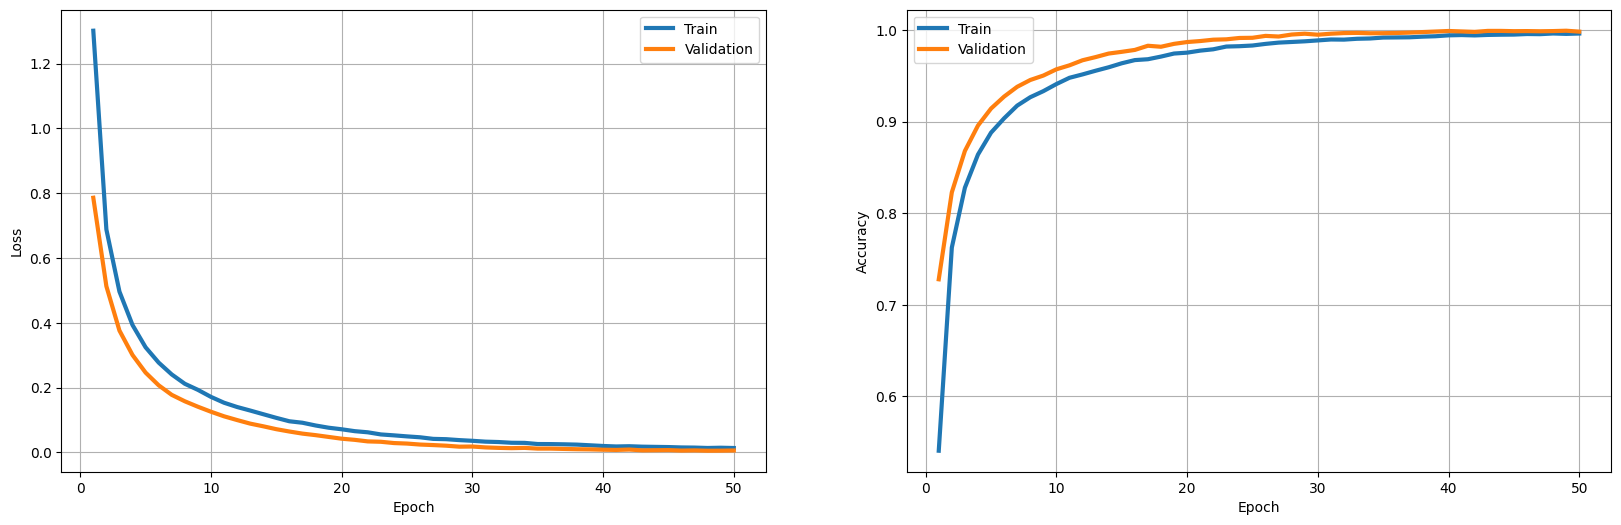

In [27]:
plot_results(N_EPOCHS, train_losses_resnet18_feat_extract, train_accs_resnet18_feat_extract, valid_losses_resnet18_feat_extract, valid_accs_resnet18_feat_extract)

In [28]:
model_testing(resnet18_feat_extract, test_iterator, criterion, device, 'resnet18_feat_extract.pt')

<ipython-input-10-21ae8c846887>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


Test -- Loss: 0.219, Acc: 94.62 %


In [29]:
print_report(resnet18_feat_extract, test_iterator, device)

[[959   2  11   4   1   0   0   1  18   4]
 [  2 974   0   0   0   0   0   0   1  23]
 [  8   0 943   5  15  15  11   1   2   0]
 [  5   0  11 868  16  71  17   5   3   4]
 [  1   0   7  10 957   8  11   6   0   0]
 [  0   0   7  61   9 909   5   6   1   2]
 [  2   1   6  11   2   0 976   0   0   2]
 [  2   1   5   8  13  12   1 958   0   0]
 [ 19   6   2   1   1   0   2   0 962   7]
 [  6  25   0   2   0   0   0   1   2 964]]


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.97      0.97      0.97      1000
           2       0.95      0.94      0.95      1000
           3       0.89      0.87      0.88      1000
           4       0.94      0.96      0.95      1000
           5       0.90      0.91      0.90      1000
           6       0.95      0.98      0.96      1000
           7       0.98      0.96      0.97      1000
           8       0.97      0.96      0.97      1000
           9       0.96   